In [ ]:
%cd /content
!git clone https://$GIT_TOKEN@github.com/yourusername/ml-car-price-regression.git
%cd ml-car-price-regression

In [17]:
!pip install -q -r requirements.txt

/content/ml-car-price-regression
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 60.7 MB/s eta 0:00:00


In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [2]:
from google.colab import files
files.upload() #kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [7]:
!unzip -q car-price-prediction.zip

df = pd.read_csv("car_price_prediction_.csv")

In [11]:
df.columns = df.columns.str.replace(" ", "_") # adjusting column names
display(df.head())      # first 5 rows
df.shape                 # how many rows x columns
df.info()                # data types + non-null counts
df.describe().T          # summary statistics for numeric features


,Car_ID,Brand,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Condition,Price,Model
0,1,Tesla,2016,2.3,Petrol,Manual,114832,New,26613.92,Model X
1,2,BMW,2018,4.4,Electric,Manual,143190,Used,14679.61,5 Series
2,3,Audi,2013,4.5,Electric,Manual,181601,New,44402.61,A4
3,4,Tesla,2011,4.1,Diesel,Automatic,68682,New,86374.33,Model Y
4,5,Ford,2009,2.6,Diesel,Manual,223009,Like New,73577.10,Mustang


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Car_ID        2500 non-null   int64  
 1   Brand         2500 non-null   object 
 2   Year          2500 non-null   int64  
 3   Engine_Size   2500 non-null   float64
 4   Fuel_Type     2500 non-null   object 
 5   Transmission  2500 non-null   object 
 6   Mileage       2500 non-null   int64  
 7   Condition     2500 non-null   object 
 8   Price         2500 non-null   float64
 9   Model         2500 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 195.4+ KB


,count,mean,std,min,25%,50%,75%,max
Car_ID,2500.0,1250.500000,721.832160,1.00,625.750,1250.50,1875.2500,2500.00
Year,2500.0,2011.626800,6.991700,2000.00,2005.000,2012.00,2018.0000,2023.00
Engine_Size,2500.0,3.465240,1.432053,1.00,2.200,3.40,4.7000,6.00
Mileage,2500.0,149749.844800,87919.952034,15.00,71831.500,149085.00,225990.5000,299967.00
Price,2500.0,52638.022532,27295.833455,5011.27,28908.485,53485.24,75838.5325,99982.59


## Distribution of price

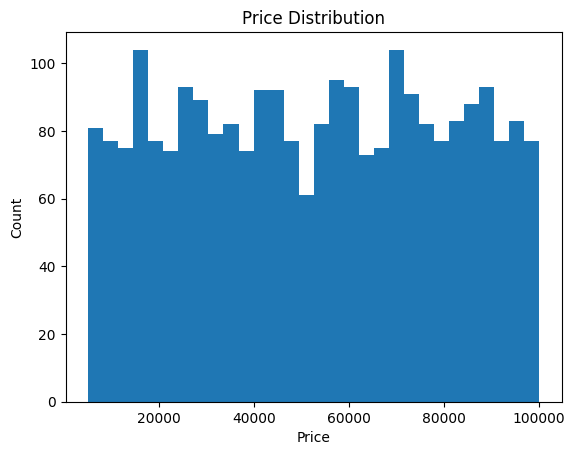

In [18]:
plt.hist(df["Price"], bins=30)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

## Category features counts

In [19]:
print(df["Fuel_Type"].value_counts())
print(df["Transmission"].value_counts())
print(df["Condition"].value_counts())

Fuel_Type
Diesel      655
Petrol      630
Electric    614
Hybrid      601
Name: count, dtype: int64
Transmission
Manual       1308
Automatic    1192
Name: count, dtype: int64
Condition
Used        855
Like New    836
New         809
Name: count, dtype: int64


## Correlation heatmap for numeric features


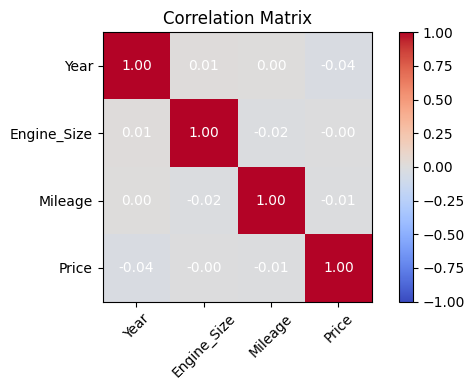

In [20]:
numeric_cols = ["Year", "Engine_Size", "Mileage", "Price"]
corr = df[numeric_cols].corr()
plt.figure(figsize=(6,4))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45)
plt.yticks(range(len(numeric_cols)), numeric_cols)
for i in range(len(numeric_cols)):
    for j in range(len(numeric_cols)):
        plt.text(j, i, f"{corr.iloc[i,j]:.2f}", ha="center", va="center", color="white")
plt.title("Correlation Matrix")
plt.colorbar()
plt.tight_layout()
plt.show()

In [21]:
X = df.drop(columns=["Car_ID", "Price"]) # dropping id-like columns
y = df["Price"] # defining the target

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42) # train/test split

In [23]:
numeric_features = ["Year", "Engine_Size", "Mileage"]
categorical_features = ["Brand", "Fuel_Type", "Transmission", "Condition", "Model"]

In [ ]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)